In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import sklearn.metrics as metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
import warnings
import optuna
import time
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
import sklearn.feature_selection as fs
from sklearn.feature_selection import SelectFromModel
from itertools import compress
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
import logging
logging.basicConfig(format='%(levelname)s - %(message)s', level=logging.INFO)
from sklearn.neighbors import KNeighborsClassifier
#oversampling
warnings.filterwarnings('ignore')
from sklearn import datasets, decomposition
%matplotlib inline


In [21]:
# class for experimentation with features and classifier methods
class FeaturesExploration:
    
    # path to dataset file
    filepath = None
    X = None
    Y = None
    dataset = None
    # scaled trained data
    X_scaled = None
    # selected training data
    X_selected = None
    feature_names = None
    
    def __init__(self,filepath):
        self.filepath = filepath
        self.dataset = pd.read_csv(self.filepath, index_col=0)

    # preprocess dataset for model input
    def dataset_preprocessing(self):
        cols_to_drop = ['Open', 'Diluted WASO']
        self.dataset = self.dataset.drop(columns=cols_to_drop)
        # handle missing values
        missing_values = self.dataset.isnull().sum()
        print('INFO: missing_values: \n', missing_values)
        self.dataset = self.dataset.fillna(0)
        inf_values = self.dataset.isin([np.inf, -np.inf]).any()
        # handle infinite values
        print('INFO: inf values: \n',inf_values[inf_values].index.tolist())
        self.dataset.replace([np.inf, -np.inf], 0, inplace=True)
        self.dataset['Return'] = self.dataset['return']
        self.dataset = self.dataset.drop(columns=['return'])
        self.feature_names = self.dataset.columns.to_list()[:-1]
        return self

    # conversion from regression to classification
    @staticmethod
    def convert_sequential_to_categorical(value):
        if value >= 0.1:
            return 1
        else:
            return 0
    
    def convert_to_classification(self):
        self.dataset['Return'] = self.dataset['Return'].apply(self.convert_sequential_to_categorical)

    def create_X_Y(self):
        self.X = self.dataset.iloc[:, :-1]
        self.Y = self.dataset.iloc[:, -1]
        print('INFO: X: ',self.X.shape)
        print('INFO: Y: ',self.Y.shape)
        return

    # elimination of features with low variance
    def prunLowVariance(self):
        var = fs.VarianceThreshold(threshold=0.5)
        var.fit(self.X)
        self.X  = var.transform(self.X)
        print("INFO: X with high variance: ", self.X.shape)
        return    
    
    def scale_data(self,onSelected=False):
        scaler = StandardScaler()
        if onSelected:
            self.X_selected = scaler.fit_transform(self.X_selected)
            return
        self.X_scaled = scaler.fit_transform(self.X)

    # experimentation with feature selection using SVM and RandomForest
    def attemptFeatureSelection(self):
        feature_names = self.dataset.columns.to_list()[:-1]
        
        X = self.dataset.iloc[:, :-1]
        Y = self.dataset.iloc[:, -1]
        
        sfm_selector = SelectFromModel(estimator=RandomForestClassifier())
        sfm_selector.fit(X, Y)
        list_of_selected_features = list(compress(feature_names, sfm_selector.get_support().tolist()))
        print("INFO: Selected features based on Random Forest: ", list_of_selected_features)

        # keep best 20 features of svm
        k_features = 20
        estimator = SVC()
        selector = SelectKBest(score_func=f_classif, k=k_features)
        selected = selector.fit_transform(X, Y)
        # Get selected feature indices
        selected_indices = selector.get_support(indices=True)
        # Get selected feature names
        selected_feature_names = [feature_names[i] for i in selected_indices]
        print("INFO: Selected features based on SVM: ", selected_feature_names)

        common_features_selected = list(set(selected_feature_names).intersection(list_of_selected_features))
        print("Features selected: ",common_features_selected)
        self.X_selected = X[common_features_selected]


    # plot impact of features in model performance
    def plot_feature_selection(self):
        model = RandomForestClassifier()
        score_list = []
        for k in range(1, 15):
            best_k = fs.SelectKBest(score_func=fs.f_classif, k=k)
            best_k.fit(self.X, self.Y)
            # get best k features from trainind dataset
            X_trans = best_k.transform(self.X)
            train_x, test_x, train_y, test_y = train_test_split(X_trans,
                                                                self.Y,
                                                                test_size=0.2,
                                                                random_state=42)
            model.fit(train_x, train_y)
            y_pred = model.predict(test_x)
            score = metrics.accuracy_score(test_y, y_pred)
            score_list.append(score)

        fig, axe = plt.subplots(dpi = 300)
        axe.plot(range(1, 15), score_list)
        axe.set_xlabel("Best k features of RndomForest")
        axe.set_ylabel("Accuracy")

    # select actual final best features
    def feautureSelection(self):
        model = RandomForestClassifier()
        best_5 = fs.SelectKBest(score_func=fs.f_classif, k=5)
        best_5.fit(self.X, self.Y)
        self.X_selected = best_5.transform(self.X)

    def plot_feature_importances(self):
        # svc feature importances
        svc = SVC()
        svc.fit(self.X, self.Y)
        # Compute distances from the decision boundary (the hyperplane)
        distances = svc.decision_function(self.X)
        # Calculate importance scores for each feature based on distances from the decision boundary
        feature_importances_svc = np.abs(np.dot(distances, self.X))
        # Normalize feature importances
        feature_importances_svc /= feature_importances_svc.sum()
        # Plot feature importances
        sorted_indices_svc = np.argsort(feature_importances_svc)[::-1]
        sorted_feature_importances_svc = feature_importances_svc[sorted_indices_svc]
        sorted_feature_names_svc = [self.feature_names[i] for i in sorted_indices_svc]
        
        plt.figure(figsize=(20, 12))
        plt.barh(range(len(sorted_feature_importances_svc)), sorted_feature_importances_svc, align='center')
        plt.yticks(np.arange(len(sorted_feature_importances_svc)), sorted_feature_names_svc)
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title('SVC Feature Importances (Default Parameters)')
        plt.show()

        # random forest feature importances
        rf = RandomForestClassifier()
        rf.fit(self.X, self.Y)
        # Get feature importances
        feature_importances_rf = rf.feature_importances_
        sorted_indices_rf = np.argsort(feature_importances_rf)[::-1]
        sorted_feature_importances_rf = feature_importances_rf[sorted_indices_rf]
        sorted_feature_names_rf = [self.feature_names[i] for i in sorted_indices_rf]
        
        plt.figure(figsize=(12, 10))
        plt.barh(range(len(sorted_feature_importances_rf)), sorted_feature_importances_rf, align='center')
        plt.yticks(np.arange(len(sorted_feature_importances_rf)), sorted_feature_names_rf)
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title('Random Forest Feature Importances')
        plt.show()

    # benchmarking of differene ml mehtods based on accuracy and speed
    def compare_methods(self,withSelection=False,withScale=False):
        # use of scaled data
        if withScale:
            x = self.X_scaled
        # use of selected data
        elif withSelection:
            x = self.X_selected
        # use of raw data
        else:
            x = self.X        
        x_train, x_test, y_train, y_test = train_test_split(x, self.Y, test_size=0.20, random_state=1, shuffle=True)
        # list with different model methods
        models = []
        models.append(("LogisticRegression", LogisticRegression()))
        models.append(("DecisionTree", DecisionTreeClassifier()))
        models.append(("SVM", SVC()))
        models.append(("RandomForest", RandomForestClassifier()))
        models.append(("Naive Bayess",GaussianNB()))
        models.append(("KNN",KNeighborsClassifier()))
        models.append(("LinearSVC",LinearSVC()))
        
        train_times = []
        test_times = []
        results = []
        names = []

        # testing of training and tesing time
        for name, model in models:
            if model is not None:
                result = cross_val_score(model, x, self.Y, cv=6, scoring='accuracy')
                results.append(result)
            start_time = time.time()
            model.fit(x_train, y_train)
            train_time = time.time() - start_time
            
            start_time = time.time()
            score = model.score(x_test, y_test)
            test_time = time.time() - start_time
            
            names.append(name)
            train_times.append(train_time)
            test_times.append(test_time)

        # Plotting
        plt.figure(figsize=(10, 10))
        plt.barh(names, train_times, color='blue', label='Training Time')
        plt.barh(names, test_times, color='red', label='Testing Time', alpha=0.5)
        plt.xlabel('Time (seconds)')
        if withScale:
            plt.title('Comparison of Training and Testing Times for Different Classifiers (Scaled Data)')
        elif withSelection:
            plt.title('Comparison of Training and Testing Times for Different Classifiers (Selected Features)')
        else:
            plt.title('Comparison of Training and Testing Times for Different Classifiers')
        plt.legend()
        plt.show()

        # testing of perfrormance
        means = []
        for i in range(len(names)):
            means.append(results[i].mean())
        plt.figure(figsize=(10, 10))
        plt.bar(names, means)
        if withScale:
            plt.title("Performance comparison (Accuracy) [Scaled Data]")
        elif withSelection:
            plt.title("Performance comparison (Accuracy) [Selected Features]")
        else:
            plt.title("Performance comparison (Accuracy)")
        plt.show()

    # export feature and label datasets
    def export_X_Y(self):
        X_df = pd.DataFrame(self.X_selected)
        X_df.to_csv('X.csv', index=False)
        Y_df = pd.DataFrame(self.Y)
        Y_df.to_csv('Y.csv', index=False)

    # plot best 3 features on the 3d plane to visually represent teh dataset via pca
    def plot_pca(self):
        X, y = self.X, self.Y
        np.random.seed(5)
        fig = plt.figure(1, figsize=(4, 3))
        plt.clf()
        ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
        ax.set_position([0, 0, 0.95, 1])
        plt.cla()
        pca = decomposition.PCA(n_components=3)
        pca.fit(X)
        X = pca.transform(X)

        for name, label in [("Below 10%", 0), ("Over 10%", 1)]:
            ax.text3D(
                X[y == label, 0].max(),
                X[y == label, 1].max() + 1.5,
                X[y == label, 2].max(),
                name,
                horizontalalignment="center",
                bbox=dict(alpha=0.5, edgecolor="w", facecolor="w"),
            )

        # Reorder the labels to have colors matching the cluster results
        y = np.choose(y, [1, 2, 0]).astype(float)
        ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.nipy_spectral, edgecolor="k")
        ax.xaxis.set_ticklabels([])
        ax.yaxis.set_ticklabels([])
        ax.zaxis.set_ticklabels([])
        plt.show()

    def plot_training_data_with_decision_boundary(self,kernel):
        # Plotting settings
        X = self.X_selected[:, :2]
        y = self.Y
        fig, ax = plt.subplots(figsize=(4, 3))
        x_min, x_max, y_min, y_max = X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

        # Plot samples by color and add legend
        scatter = ax.scatter(X[:, 0], X[:, 1], s=150, c=y, label=y, edgecolors="k")
        ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
        ax.set_title("Samples in two-dimensional feature space")
        plt.show()
        
        # Train the SVC
        from sklearn import svm
        from sklearn.inspection import DecisionBoundaryDisplay
        
        clf = svm.SVC(kernel=kernel, gamma=2).fit(X, y)

        # Settings for plotting
        _, ax = plt.subplots(figsize=(4, 3))
        x_min, x_max, y_min, y_max = X[:, 0].min(), X[:, 0].max(), X[:, 1].min(), X[:, 1].max()
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

        # Plot decision boundary and margins
        common_params = {"estimator": clf, "X": X, "ax": ax}
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="predict",
            plot_method="pcolormesh",
            alpha=0.3,
        )
        DecisionBoundaryDisplay.from_estimator(
            **common_params,
            response_method="decision_function",
            plot_method="contour",
            levels=[-1, 0, 1],
            colors=["k", "k", "k"],
            linestyles=["--", "-", "--"],
        )

        # Plot bigger circles around samples that serve as support vectors
        ax.scatter(
            clf.support_vectors_[:, 0],
            clf.support_vectors_[:, 1],
            s=250,
            facecolors="none",
            edgecolors="k",
        )
        # Plot samples by color and add legend
        ax.scatter(X[:, 0], X[:, 1], c=y, s=150, edgecolors="k")
        ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
        ax.set_title(f" Decision boundaries of {kernel} kernel in SVC")

        plt.show()
        



In [22]:
experiments = FeaturesExploration("Final_dataset.csv")
experiments.dataset_preprocessing()
experiments.convert_to_classification()

INFO: missing_values: 
 Total Assets                                                      0
Total Current Assets                                              0
Total Non-Current Assets                                          0
Total Liabilities                                                 0
Total Current Liabilities                                         0
Total Non-Current Liabilities                                     0
Total Equity                                                      0
Cash Generated from Operating Activities                          0
Income/Loss before Non-Cash Adjustment                            0
Changes in Operating Capital                                      0
Cash Flow from Investing Activities                               0
Cash Flow from Financing Activities                               0
Change in Cash                                                    0
Cash and Cash Equivalents, Beginning of Period                    0
Gross Profit            

In [23]:
experiments.attemptFeatureSelection()

INFO: Selected features based on Random Forest:  ['Cash Generated from Operating Activities', 'Changes in Operating Capital', 'Cash Flow from Investing Activities', 'Cash Flow from Financing Activities', 'Change in Cash', 'Diluted EPS', 'Gross Margin', 'Net Income to Total Assets ratio', 'Gross Profit to Total Equity ratio', 'Price to Total Current Assets ratio', 'Price to Cash Generated from Operating Activities ratio', 'Price to Income/Loss before Non-Cash Adjustment ratio', 'Price to Changes in Operating Capital ratio', 'Price to Cash Flow from Investing Activities ratio', 'Price to Cash Flow from Financing Activities ratio', 'Price to Change in Cash ratio', 'Price to Cash and Cash Equivalents, Beginning of Period ratio', 'Price to Diluted EPS ratio', 'Price to Net Income ratio']
INFO: Selected features based on SVM:  ['Total Non-Current Assets', 'Total Non-Current Liabilities', 'Income/Loss before Non-Cash Adjustment', 'Cash Flow from Investing Activities', 'Cash Flow from Financin

In [24]:
experiments.create_X_Y()
experiments.scale_data()

INFO: X:  (3944, 47)
INFO: Y:  (3944,)


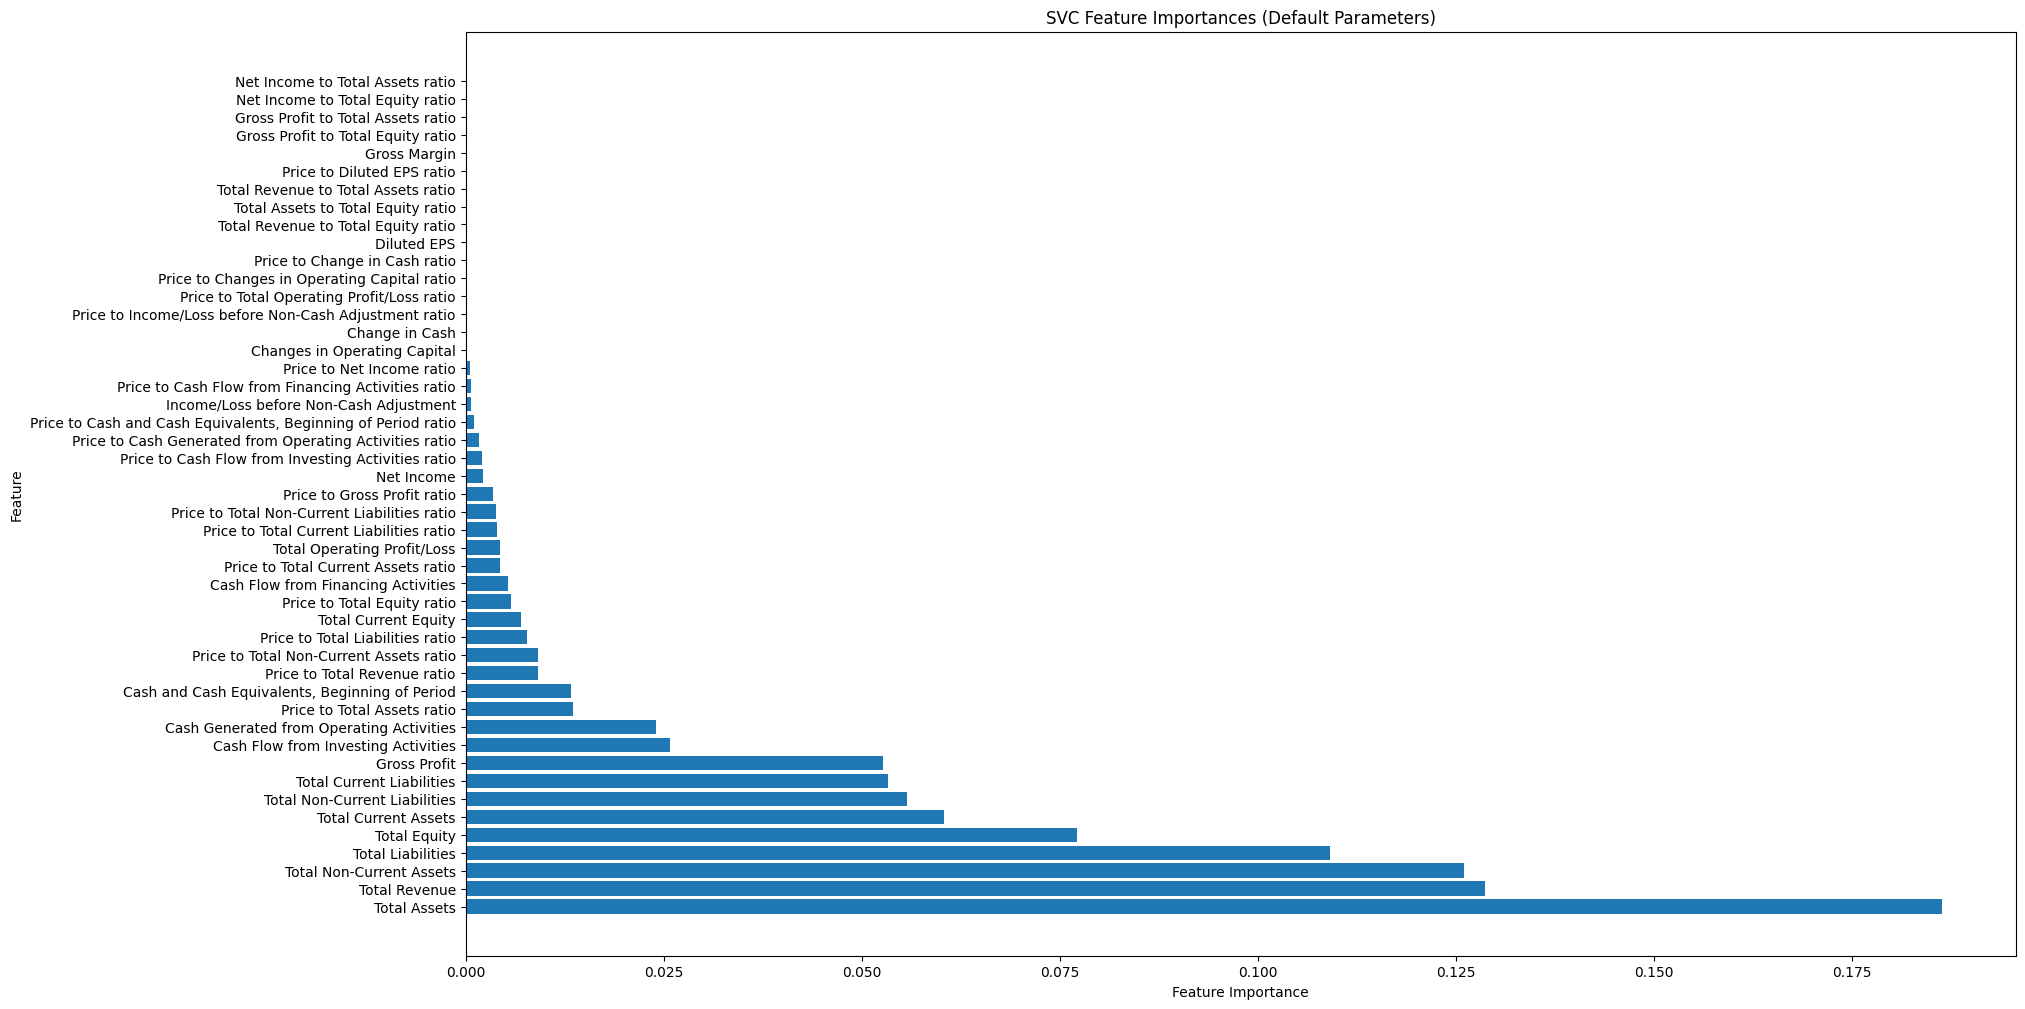

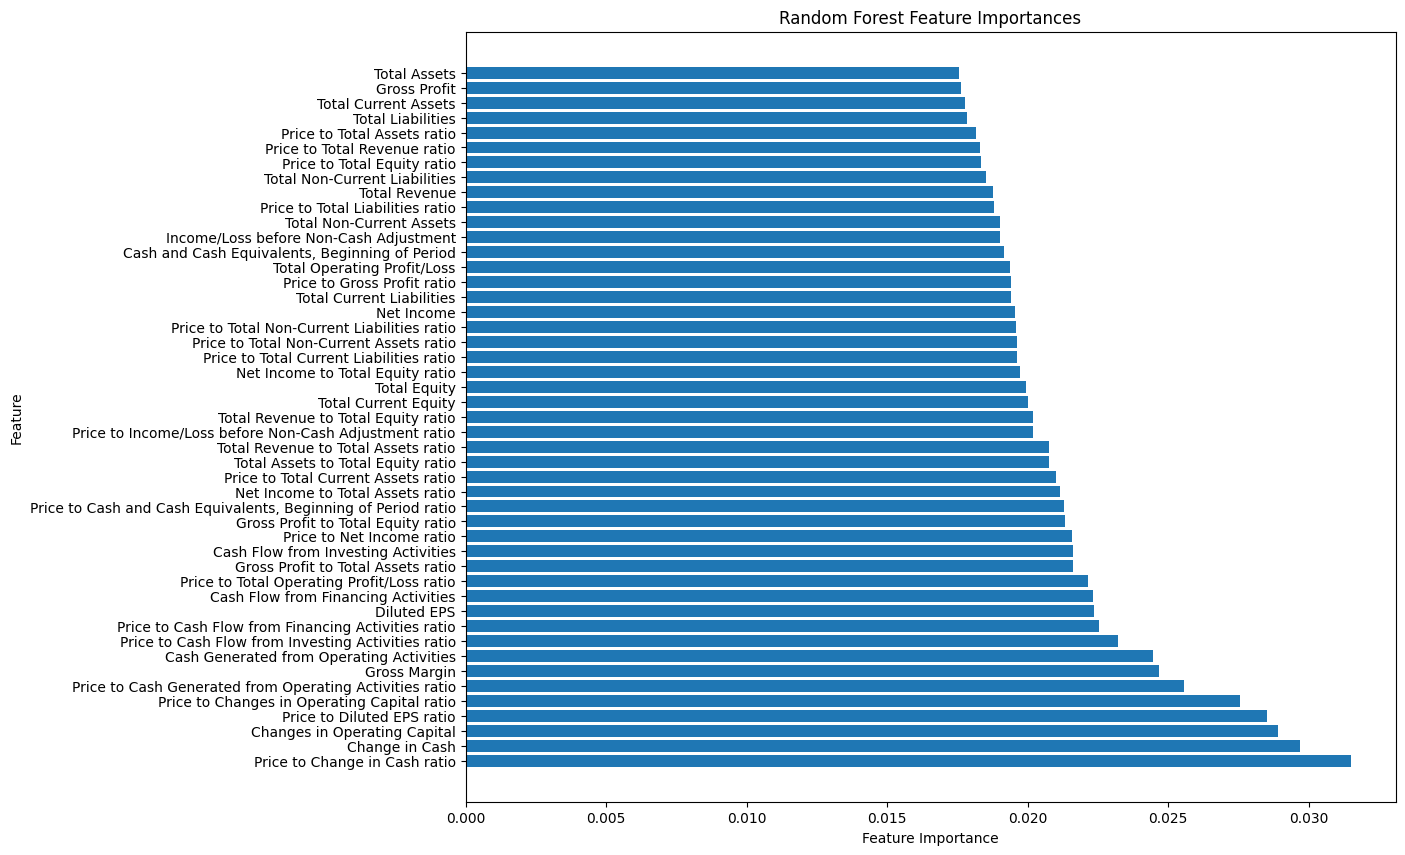

In [25]:
experiments.plot_feature_importances()

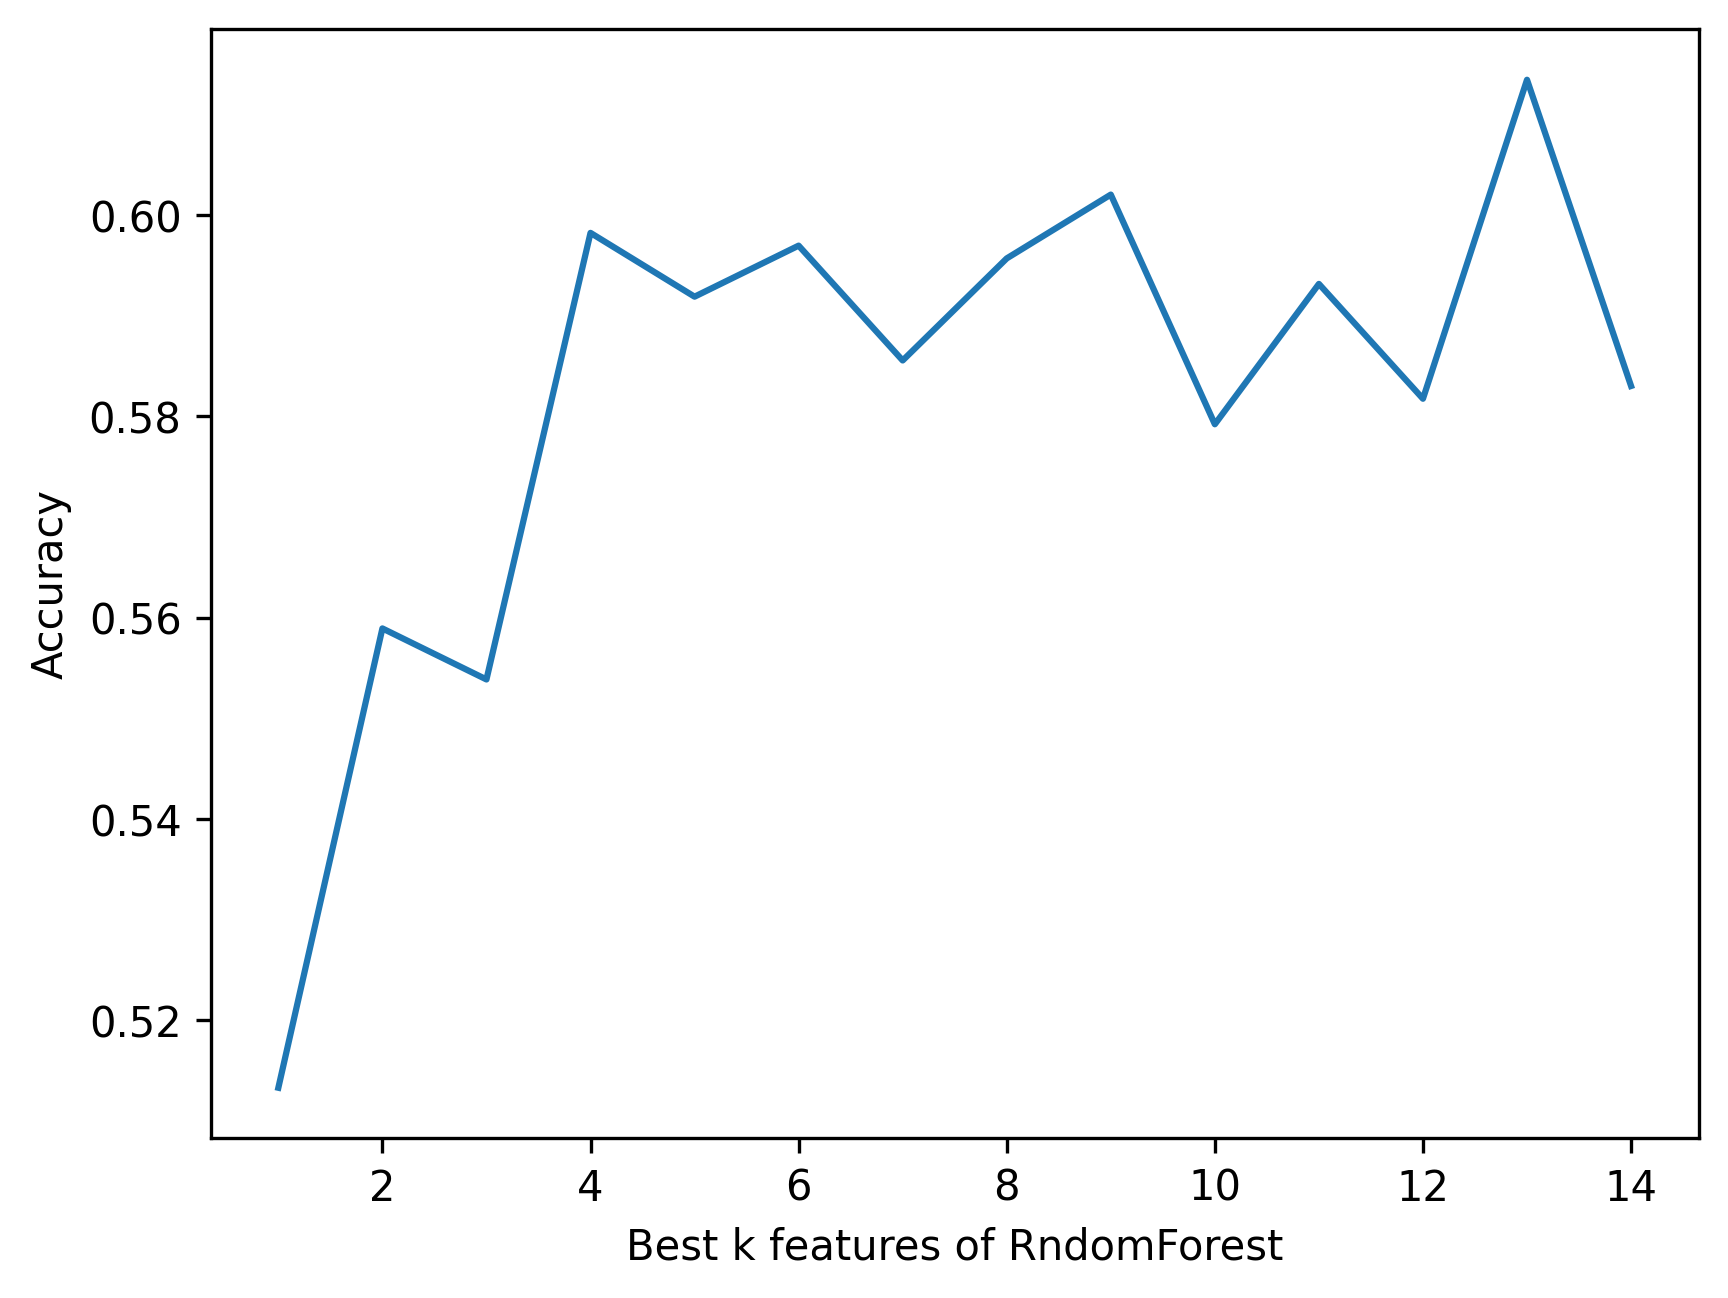

In [26]:
experiments.plot_feature_selection()

In [27]:
experiments.feautureSelection()

In [28]:
experiments.prunLowVariance()

INFO: X with high variance:  (3944, 43)


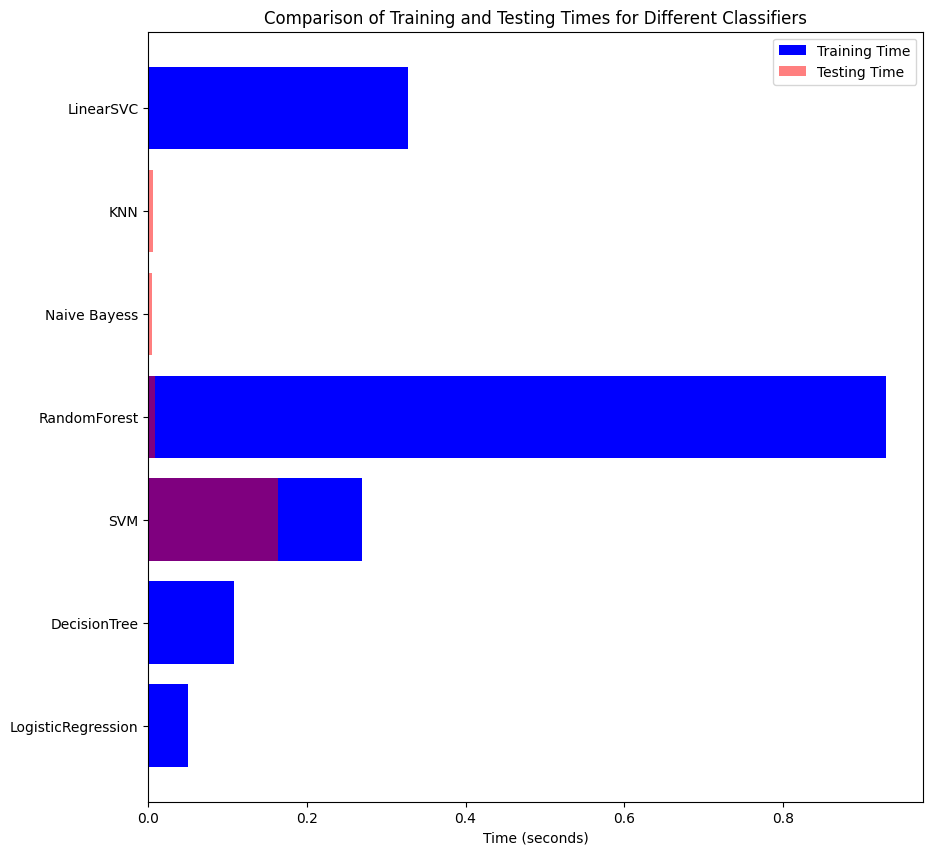

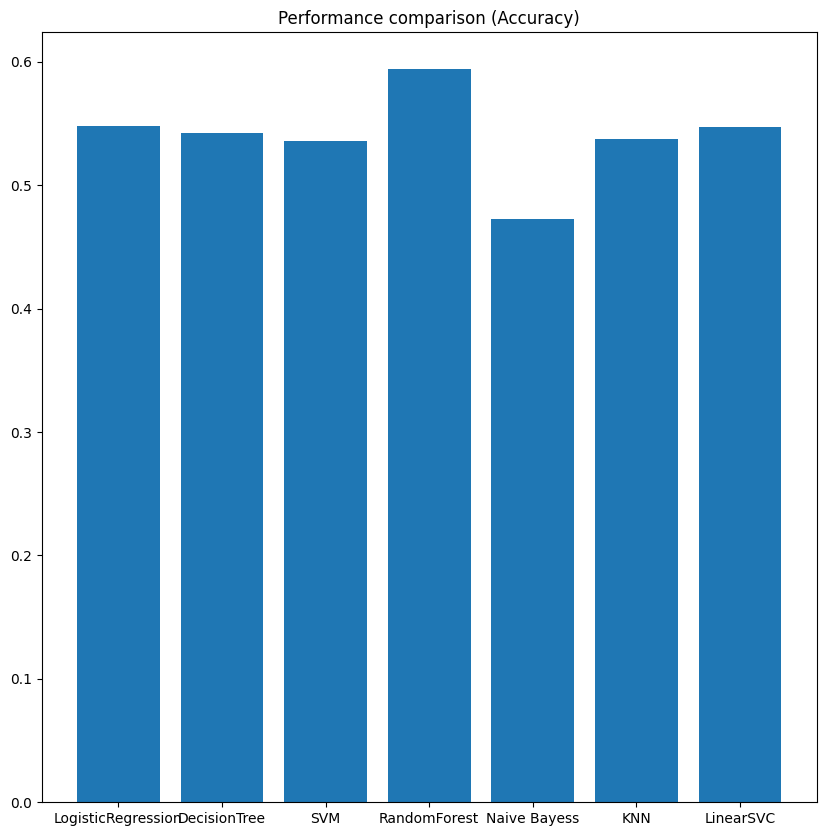

In [29]:
experiments.compare_methods()

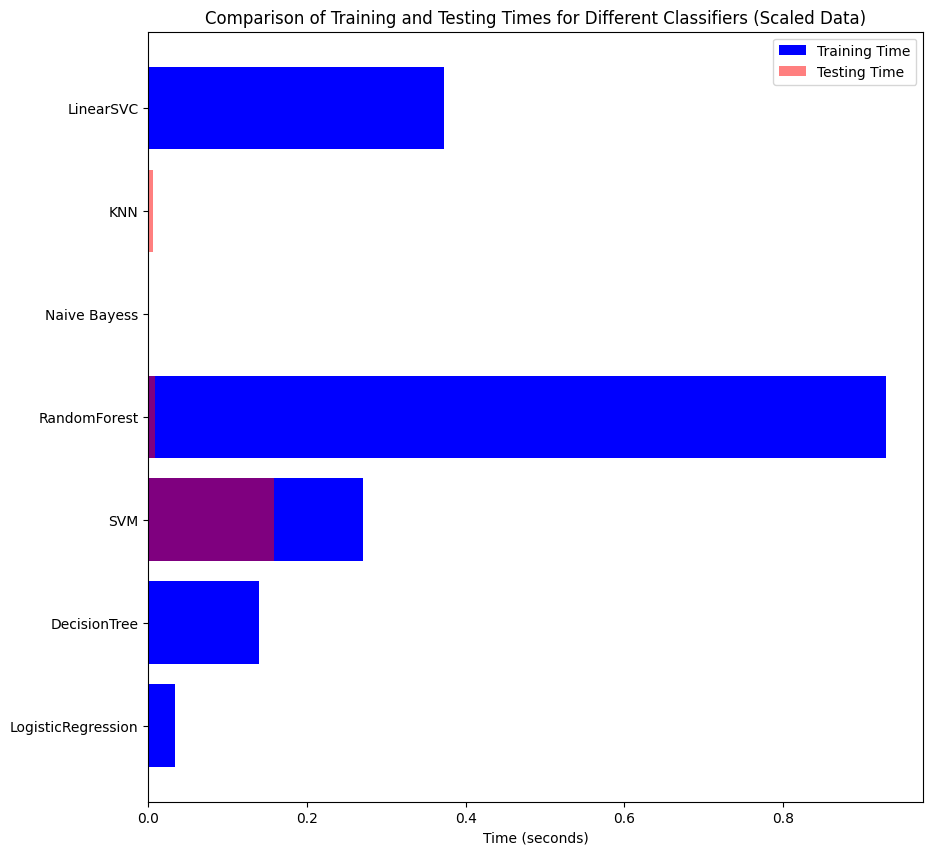

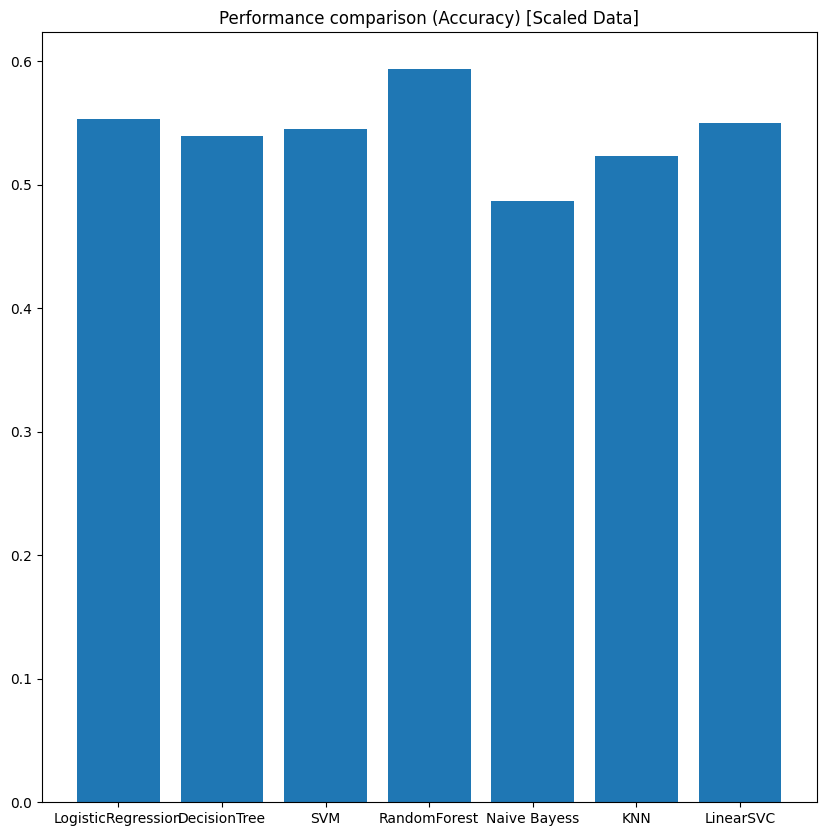

In [30]:
experiments.compare_methods(withScale=True)

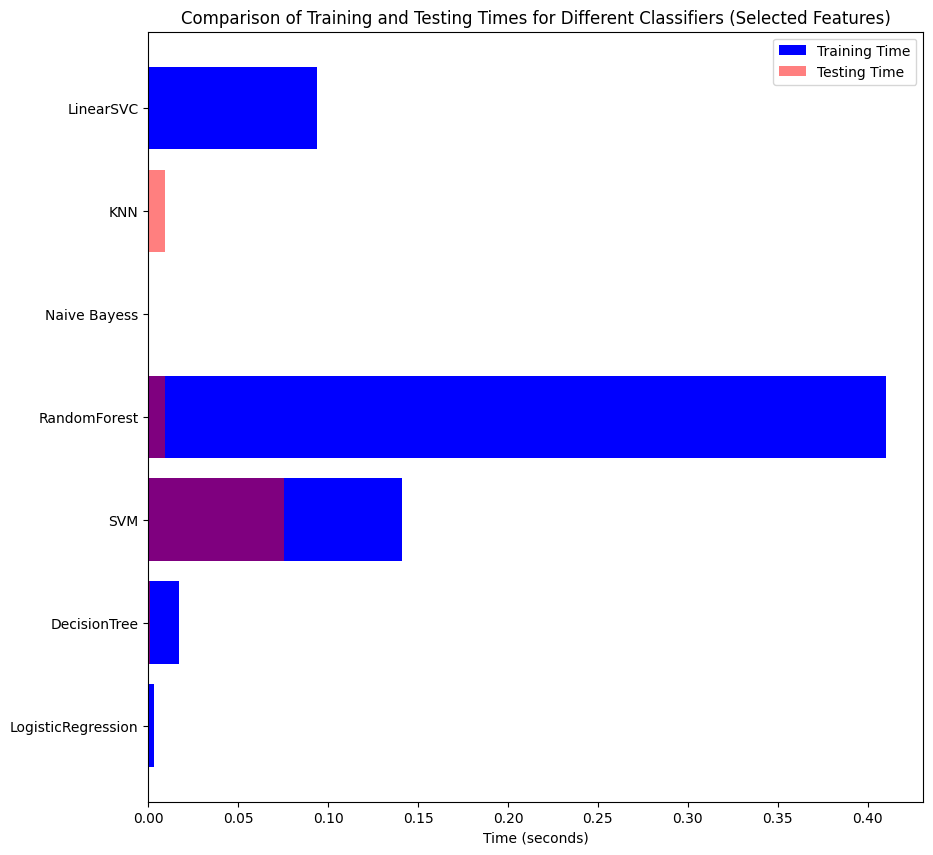

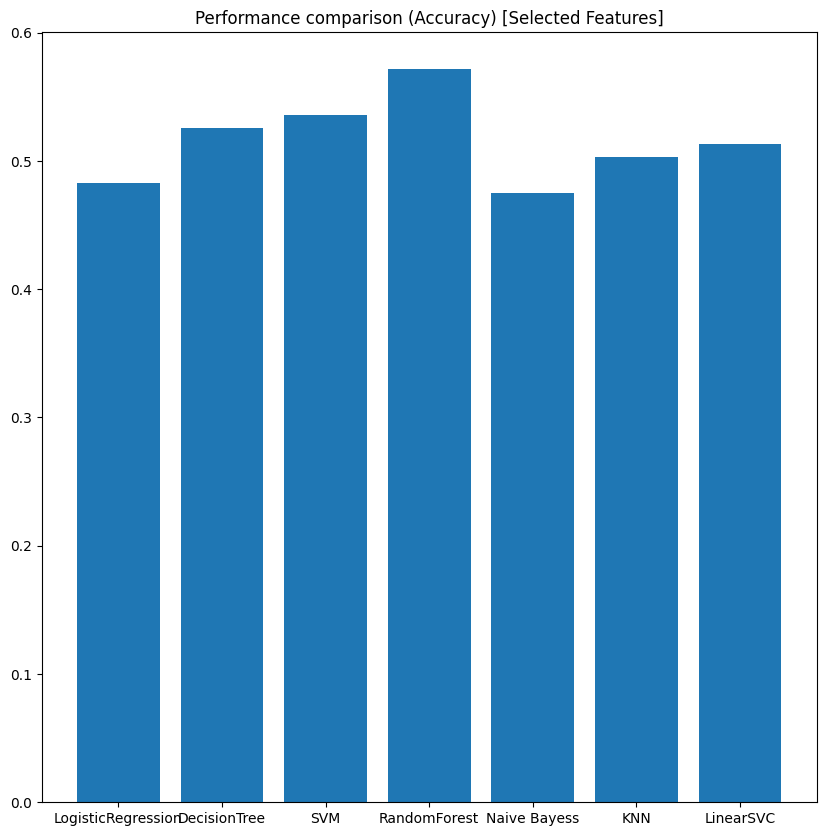

In [31]:
experiments.compare_methods(withSelection=True)

In [32]:
experiments.scale_data(onSelected=True)

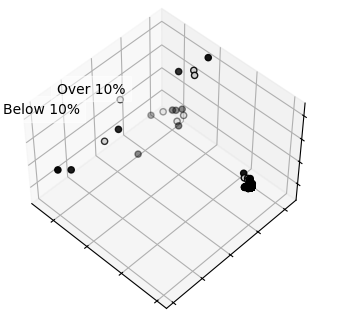

In [33]:
experiments.plot_pca()

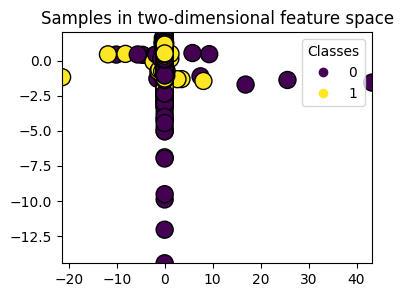

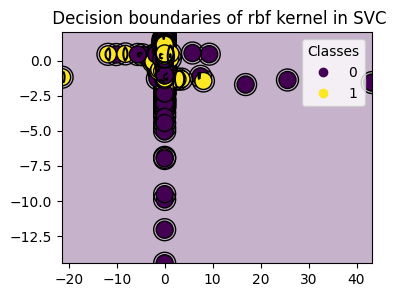

In [34]:
experiments.plot_training_data_with_decision_boundary("rbf")

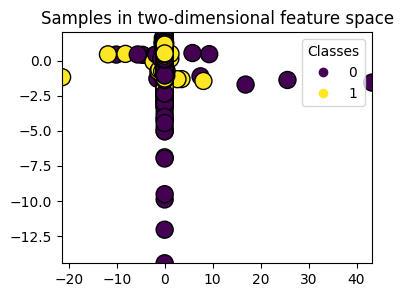

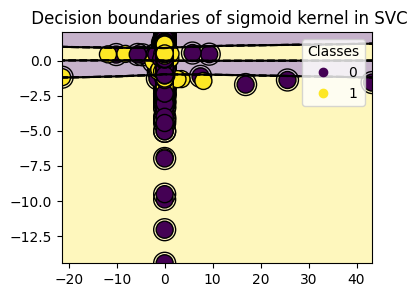

In [35]:
experiments.plot_training_data_with_decision_boundary("sigmoid")

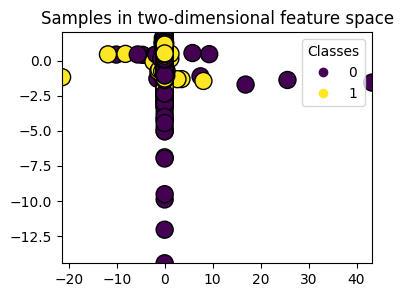

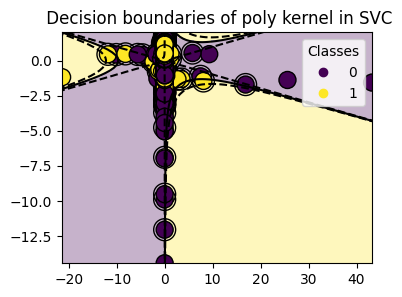

In [38]:
experiments.plot_training_data_with_decision_boundary("poly")

In [37]:
experiments.export_X_Y()